In [1]:
# ============================
# Import Necessary Libraries
# ============================

import matplotlib.pyplot as plt
import numpy as np 
import sys, warnings
from skimage.feature import peak_local_max
import seaborn as sns
#sys.path.append('..')
import salat
warnings.filterwarnings("ignore")

In [2]:
class ALMADataProcessor:
    """
    Processes ALMA cube data, enabling statistical analysis, local extrema detection,
    and coordinate transformations.

    Attributes:
        file_path (str): Path to the ALMA data file.
        almacube (np.ndarray): ALMA data cube.
        header (dict): Metadata from the ALMA file.
        timesec (float): Time in seconds.
        timeutc (str): Time in UTC format.
        beammajor (float): Major axis of the beam.
        beamminor (float): Minor axis of the beam.
        beamangle (float): Angle of the beam.
        pixel_size_arcsec (float): Pixel size in arcseconds.
    """

    def __init__(self, file_path):
        """
        Initializes the ALMA data processor by reading the specified ALMA file.

        Args:
            file_path (str): Path to the ALMA data file.
        """
        self.file_path = file_path
        # Read the ALMA file and store data and metadata
        self.almacube, self.header, self.timesec, self.timeutc, \
            self.beammajor, self.beamminor, self.beamangle = self._read_alma_file()

        # Retrieve pixel size in arcseconds from the header
        self.pixel_size_arcsec = self.header['CDELT1A']

    def _read_alma_file(self):
        """
        Reads the ALMA file using the salat module.

        Returns:
            tuple: Contains the ALMA cube, header, and other metadata.
        """
        return salat.read(
            self.file_path,
            timeout=True,
            beamout=True,
            HEADER=True,
            SILENT=False,
            fillNan=True
        )

    def compute_alma_cube_statistics(self, plot_histogram=False):
        """
        Calculates statistics (mean and standard deviation) of the ALMA cube.

        Args:
            plot_histogram (bool, optional): If True, plots a histogram of the data. Defaults to False.

        Returns:
            tuple: Mean and standard deviation of the ALMA cube data.
        """
        # Flatten each image in the ALMA cube and remove values equal to the first pixel
        alma_flatten = [
            np.delete(img.flatten(), np.where(img.flatten() == img[0][0]))
            for img in self.almacube
        ]
        # Concatenate all flattened data into a single array
        flatten_all_alma = np.concatenate(alma_flatten)
        # Calculate standard deviation and mean
        std_alma_cube = np.std(flatten_all_alma)
        mean_alma_cube = np.mean(flatten_all_alma)

        # If requested, plot the histogram
        if plot_histogram:
            self._plot_histogram(flatten_all_alma, mean_alma_cube, std_alma_cube)

        return mean_alma_cube, std_alma_cube

    def _plot_histogram(self, data, mean, std):
        """
        Plots a histogram of the data with lines indicating the mean and various standard deviations.

        Args:
            data (np.ndarray): Data to be plotted in the histogram.
            mean (float): Mean of the data.
            std (float): Standard deviation of the data.
        """
        plt.figure(figsize=(10, 6))
        # Create the histogram
        n, bins, patches = plt.hist(
            data,
            bins=100,
            density=True,
            color='#80c1ff',
            alpha=0.6
        )
        # Add vertical lines for different standard deviation levels
        plt.axvline(
            x=mean - std * 1.5,
            color='#1f77b4',
            linestyle='--',
            linewidth=2,
            label='Mean - 1.5 Sigmas')
        plt.axvline(
            x=mean - std,
            color='#ff7f0e',
            linestyle='-',
            linewidth=2,
            label='Mean - 1.0 Sigma')
        plt.axvline(
            x=mean - std * 2.0,
            color='#2ca02c',
            linestyle=':',
            linewidth=2,
            label='Mean - 2.0 Sigmas')
        plt.axvline(x=mean, color='red',
                    linestyle='-',
                    linewidth=2,
                    label='Mean')
        # Configure grid and labels
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlabel('Temperature (K)', fontsize=12, fontweight='bold')
        plt.ylabel('Density', fontsize=12, fontweight='bold')
        plt.title('Histogram of ALMA Cube Data', fontsize=14, fontweight='bold')
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
        plt.tight_layout()
        plt.show()

    def get_local_extrema_pos(
            self,
            img,
            mdist,
            std_all_cube,
            sigma_criterion,
            maxima=True,
            pixels=True):
        """
        Retrieves the positions of local extrema (maxima or minima) in an image.

        Args:
            img (np.ndarray): Image in which to search for local extrema.
            mdist (int): Minimum distance between local extrema.
            std_all_cube (float): Standard deviation of the ALMA cube.
            sigma_criterion (float): Sigma-based criterion for the threshold.
            maxima (bool, optional): If True, searches for local maxima; otherwise, minima. Defaults to True.
            pixels (bool, optional): If True, the distance is in pixels; if False, in arcseconds. Defaults to True.

        Returns:
            np.ndarray: Coordinates of the detected local extrema.
        """
        mean_temp = img[0][0]
        # Calculate the adjusted minimum distance based on whether it's in pixels
        # or arcseconds
        mindist = int(mdist) + 1 if pixels else int(mdist / self.pixel_size_arcsec) + 1

        if maxima:
            # Search for local maxima with minimum distance and relative threshold
            return peak_local_max(img, min_distance=mindist, threshold_rel=0.25)
        else:
            # Calculate an absolute threshold based on mean and sigma criterion
            threshold_abs = -mean_temp + std_all_cube * sigma_criterion
            # Search for local minima by inverting the image
            return peak_local_max(-img, min_distance=mindist,
                                  threshold_abs=threshold_abs)

    def detect_local_extrema(
            self,
            sigma_criterion,
            times_radio=2,
            plot_histogram=False):
        """
        Detects local extrema across the entire ALMA cube.

        Args:
            sigma_criterion (float): Sigma-based criterion for the threshold.
            times_radio (int, optional): Multiplicative factor to calculate distance. Defaults to 2.
            plot_histogram (bool, optional): If True, plots the data histogram. Defaults to False.

        Returns:
            list: List of arrays containing positions of local extrema per frame.
        """
        # Calculate ALMA cube statistics
        _, std_alma_cube = self.compute_alma_cube_statistics(plot_histogram)
        # Calculate distance based on beam radius and pixel size

        distance = times_radio * (
            np.sqrt(np.mean(self.beammajor) * np.mean(self.beamminor))
            / self.pixel_size_arcsec
        )
        # Detect local minima in each frame of the cube
        return [
            self.get_local_extrema_pos(
                frame,
                distance,
                std_alma_cube,
                sigma_criterion,
                maxima=False,
                pixels=True
            )
            for frame in self.almacube
        ]

    def filter_points(
            self,
            point_vector,
            frame,
            distance_threshold=0,
            plot_minimums=False):
        """
        Filters detected points that are within a distance threshold from the reference point.

        Args:
            point_vector (list): List of arrays containing point positions per frame.
            frame (int): Index of the current frame.
            distance_threshold (float, optional): Distance threshold for filtering points. Defaults to 0.
            plot_minimums (bool, optional): If True, plots the filtered points on the image. Defaults to False.

        Returns:
            np.ndarray: Filtered points that meet the distance threshold.
        """
        # Retrieve points for the specified frame
        points = np.array(point_vector[frame].copy())
        # Define the reference point as the center of the image
        reference_point = np.array([
            self.almacube.shape[1] / 2,
            self.almacube.shape[2] / 2
        ])
        # Calculate distances from each point to the reference point
        distances = np.linalg.norm(points - reference_point, axis=1)
        # Filter points within the distance threshold
        filtered_points = points[distances <= distance_threshold]

        # If requested, plot the filtered points
        if plot_minimums:
            self._plot_filtered_points(frame, filtered_points)

        return filtered_points

    def _plot_filtered_points(self, frame, filtered_points):
        """
        Plots the filtered points over the corresponding frame image.

        Args:
            frame (int): Index of the current frame.
            filtered_points (np.ndarray): Filtered points to be plotted.
        """
        plt.figure(figsize=(6, 6))
        plt.title(f'Frame {frame}, {self.timeutc[frame]} UTC')
        # Display the image of the frame
        plt.imshow(
            self.almacube[frame],
            origin='lower',
            cmap='hot'
        )
        # Plot the filtered points with a label for the legend
        plt.scatter(
            filtered_points[:, 1],
            filtered_points[:, 0],
            color='blue',
            label='Local Minimum detected',  # Add label for the legend
            s=25  # Adjust marker size
        )
        # Add legend to the plot
        plt.legend(loc='upper right')


        plt.show()

    def transform_coords(self, coords, matrix_size, extent):
        """
        Transforms pixel coordinates to physical coordinates.

        Args:
            coords (np.ndarray): Pixel coordinates (y, x).
            matrix_size (int): Size of the image matrix.
            extent (tuple): Physical extent of the image in (xmin, xmax, ymin, ymax).

        Returns:
            tuple: Transformed coordinates (x_new, y_new).
        """
        # Calculate pixel size in each axis
        y_pixel_size = (extent[1] - extent[0]) / matrix_size
        x_pixel_size = (extent[3] - extent[2]) / matrix_size
        # Transform the coordinates
        x_new = extent[0] + coords[:, 1] * x_pixel_size
        y_new = extent[2] + coords[:, 0] * y_pixel_size
        return x_new, y_new

    def compute_trajectory(
            self,
            selected_point,
            time_0_frame,
            umbral_same_point,
            vector_min_0_diameter,
            scand):
        """
        Computes the trajectory of a selected point across different frames.

        Args:
            selected_point (np.ndarray): Selected point to track.
            time_0_frame (int): Initial time frame.
            umbral_same_point (float): Threshold to determine if the point remains the same.
            vector_min_0_diameter (list): List of minimum points per frame.
            scand (tuple): Range of frames to consider (start, end).

        Returns:
            tuple: Coordinates of local minima along the trajectory and their corresponding frame indices.
        """
        def closest_node(node, nodes):
            """
            Finds the closest node to a given point.

            Args:
                node (np.ndarray): Reference point.
                nodes (np.ndarray): Array of points to search.

            Returns:
                tuple: Index of the closest node and the distance to it.
            """
            nodes = np.asarray(nodes)
            dist_2 = np.sum((nodes - node) ** 2, axis=1)
            return np.argmin(dist_2), np.sqrt(min(dist_2))

        # Copy of the selected point for manipulation
        variable_muda = selected_point.copy()
        vec_min_backward = []  # List of points going backward in time
        index_backward = []     # List of frame indices going backward
        vec_min_forward = []   # List of points going forward in time
        index_forward = []      # List of frame indices going forward

        # Iterate backward from the initial frame to the start of the range
        for i in range(time_0_frame - 1, scand[0], -1):
            index_distance_i_point, distance_pixel = closest_node(
                variable_muda, vector_min_0_diameter[i])
            # If the distance exceeds the threshold, stop the search
            if distance_pixel > umbral_same_point:
                break
            # Update the reference point
            variable_muda = vector_min_0_diameter[i][index_distance_i_point].copy()
            vec_min_backward.append(vector_min_0_diameter[i][index_distance_i_point])
            index_backward.append(i)

        # Reset the reference point to the selected point for forward iteration
        variable_muda = selected_point.copy()
        # Iterate forward from the initial frame to the end of the range
        for i in range(time_0_frame, scand[1] - 1, 1):
            index_distance_i_point, distance_pixel = closest_node(
                variable_muda, vector_min_0_diameter[i])
            # If the distance exceeds the threshold, stop the search
            if distance_pixel > umbral_same_point:
                break
            # Update the reference point
            variable_muda = vector_min_0_diameter[i][index_distance_i_point].copy()
            vec_min_forward.append(vector_min_0_diameter[i][index_distance_i_point])
            index_forward.append(i)

        # Concatenate the backward and forward points, ordering the indices
        all_local_min = np.concatenate((
            np.flipud(np.array(vec_min_backward)),
            np.array(vec_min_forward)
        ))
        total_index = np.array(sorted(index_backward + index_forward))

        return all_local_min, total_index



---------------------------------------------------
--------------- SALAT READ part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --

Reading ALMA cube



100%|██████████| 1608/1608 [00:00<00:00, 34155.29it/s]


---------------------------------------------------
--------------- SALAT INFO part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --


----------------------------------------------
| Data feat.: 
----------------------------------------------
|  ALMA BAND:  3
|  Obs. Date:  2018-04-12
|  ALMA proj:  2017.1.00653.S
|  Pix. Unit:  K
|  Pix. Size:  0.3  arcsec.
|  Beam mean:  2.15798  arcsec
|  FOV. diam:  notcomputed
----------------------------------------------
| Data range 
----------------------------------------------
|  Min =  5260.81054688  Kelvin
|  Max =  10677.8203125  Kelvin
----------------------------------------------

Done!


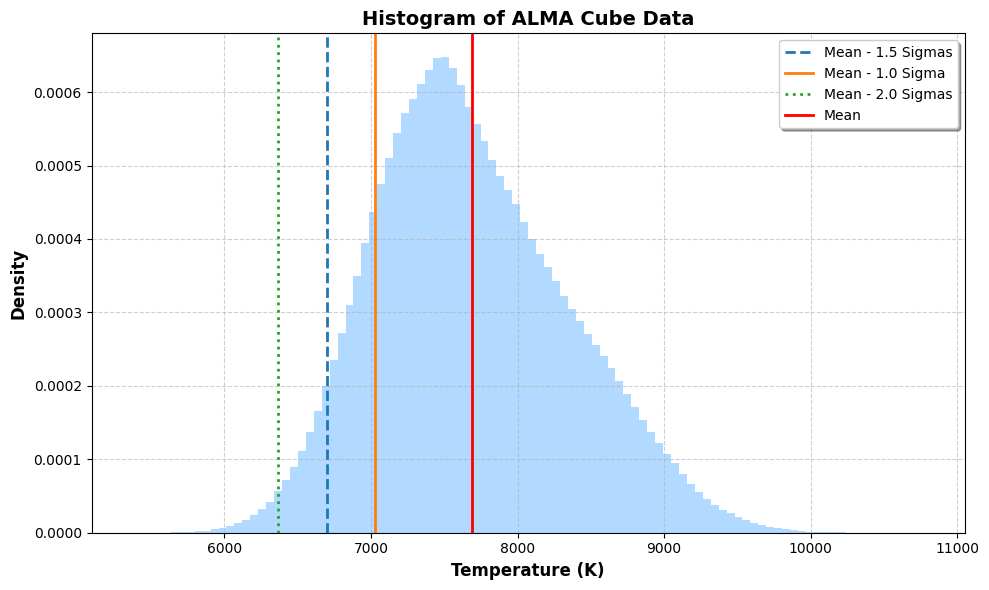

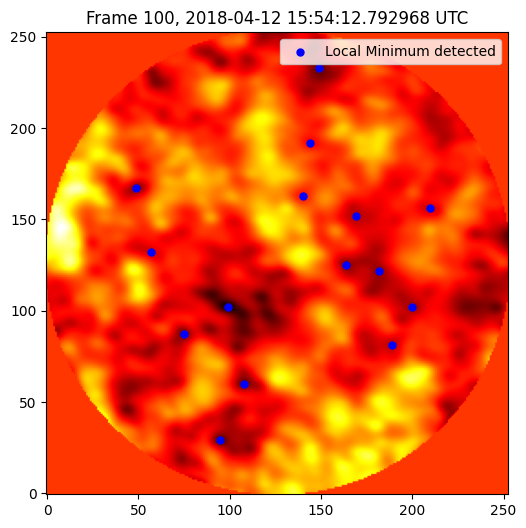

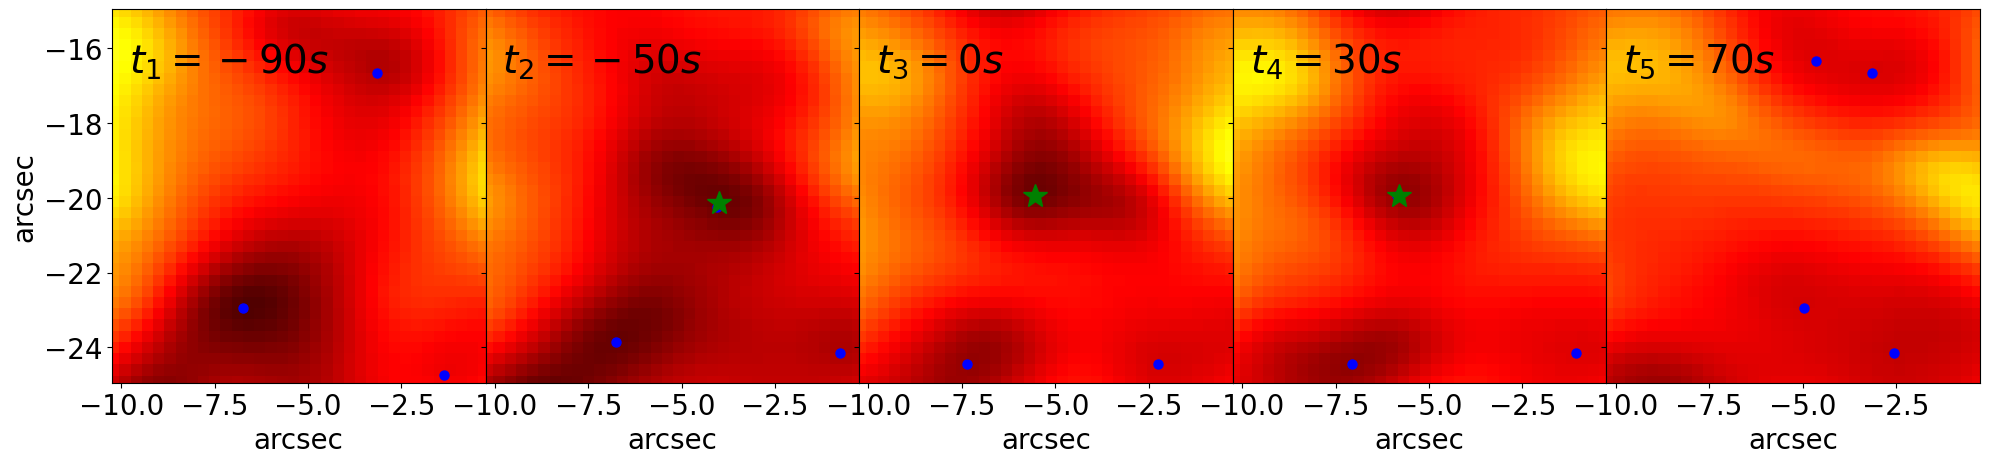

In [3]:

# Example usage
if __name__ == "__main__":
    path_ALMA = '/media/javier/SSD_2/OtrasRegiones/{}'
    file = path_ALMA.format(
        'D06_solaralma.b3.fba.20180412_155228-162441.2017.1.00653.S.level4.k.fits')

    processor = ALMADataProcessor(file)

    std_alma_cube = processor.compute_alma_cube_statistics(plot_histogram=False)

    vector_min_0_diameter = processor.detect_local_extrema(
        sigma_criterion=0, times_radio=0, plot_histogram=False)
    vector_min_2_diameter = processor.detect_local_extrema(
        sigma_criterion=0, times_radio=2, plot_histogram=True)

    frame = 100
    minimum_num = 3
    radius_with_search_mininums = 110
    points_data_track = processor.filter_points(
        vector_min_2_diameter,
        frame=frame,
        distance_threshold=radius_with_search_mininums,
        plot_minimums=True)

    selected_point = points_data_track[minimum_num].copy()

    distance = (
        np.sqrt(np.mean(processor.beammajor) * np.mean(processor.beamminor))
        / processor.pixel_size_arcsec)

    scand = [0, processor.almacube.shape[0]]  # Adjust as needed

    all_local_min, total_index = processor.compute_trajectory(
        selected_point, frame, distance, vector_min_0_diameter, scand)
    

    # Important comment for the user
    # Note: This HARD CODE only works for this particular 
    # example and for the selected local minimum.
    # Since every local minimum appears at different window times, 
    # it may be difficult to create a general solution.
    # You should edit this part manually for the ALMA observation 
    # you are using and the local minimum of interest.

    matrix_size =253  # ALMA image size  253x253
    marker_size =18   # window size center in local minumun
    
    #
    extent = [-matrix_size*0.3/2, matrix_size*0.3/2, -matrix_size*0.3/2, matrix_size*0.3/2]


    t_1, t_2, t_3, t_4,  t_5 = 10, 50, 100, 130, 170

    fontsize = 20
    marker_size =18

    time_labels = ['$t_1=-90s$', '$t_2=-50s$', '$t_3=0s$', '$t_4=30s$', '$t_5=70s$']  # Etiquetas para cada subplot en formato LaTeX
    fig, axs = plt.subplots(1, 5, figsize=(20,20), sharey=True, constrained_layout=True, gridspec_kw = {'wspace':0, 'hspace':0})

    # Configurar cada subgráfica
    for ax, t in zip(axs, [t_1, t_2, t_3, t_4, t_5]):
        ax.imshow(processor.almacube[t], origin='lower', cmap='hot', extent=extent)
        x_transformed, y_transformed = processor.transform_coords(vector_min_0_diameter[t], matrix_size, extent)
        ax.plot(x_transformed, y_transformed, 'b.',markersize=marker_size-5)
        ax.set_ylim(-19.95 -5 , -19.95 +5)
        ax.set_xlim(-5.25  -5 , -5.25  +5)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.set_xlabel('arcsec', fontsize=fontsize)

    for i in range(5):
        axs[i].text(-9.8, -15.8, f'{time_labels[i]}', fontsize=fontsize+8, fontweight='bold', va='top')
    
    axs[1].plot(-4  , -20.15     , 'g*',markersize=marker_size)
    axs[2].plot(-5.55  , -19.95  , 'g*',markersize=marker_size)
    axs[3].plot(-5.79  , -19.95  , 'g*',markersize=marker_size)

    axs[0].set_ylabel('arcsec', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig('example_tracking.jpg',dpi=100,bbox_inches='tight')
    plt.show()  
